# Классификация и градиентные спуски :) 

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [2]:
X = pd.read_csv('X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('y_cat.csv', sep = '\t', index_col=0,  names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [3]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [4]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [6]:
len(y)

26729

In [7]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 2. Архитектурка

In [10]:


from tensorflow.keras import layers as L         # Уже готовые слои для моделей
from tensorflow.keras.models import Sequential   # Специальный класс для склеивания слоёв
from tensorflow.keras.models import Model        # Альтернативный класс для склейки слоёв
import tensorflow.keras.optimizers as opt        # Разные оптимизационные алгоритмы :3       # Оптимизаторы

# Для преобразования y в категориальный формат 
from tensorflow.keras.utils import to_categorical  

Функция для картинок с прошлой пары.

In [11]:
def plot_history(histories, key='loss', start=0):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch[start:], history.history['val_'+key][start:],
                       #'--', 
                       label=name.title()+' Val')
            #plt.plot(history.epoch[start:], history.history[key][start:], color=val[0].get_color(),
            #     label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([start, max(history.epoch)])
    pass

Переменную $y$ для успешного обучения сетки нужно будет перевести в матрицу из дамми-переменных с помощью команды `to_categorical`.  У нас тут как-бы __Softmax.__ 

In [12]:
y_train[:10]

array([3, 3, 1, 0, 1, 3, 2, 0, 0, 3])

In [13]:
# переводим, так как затем будем считать кросс-экнтропию 
to_categorical(y_train[:10])

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
batch_size = 1000
epochs = 100
learning_rate = 0.001

def fn_model() : 
    model = Sequential()
    
    model.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))
    
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))
    
    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))
    return model

# 3. Оптимизация 

### SGD 

In [16]:
# Первая простенькая моделька 
model1 = fn_model()

# SGD optimizer
sgd = opt.SGD(lr=learning_rate, momentum=0.0, nesterov=False)

# собрали модель
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0)

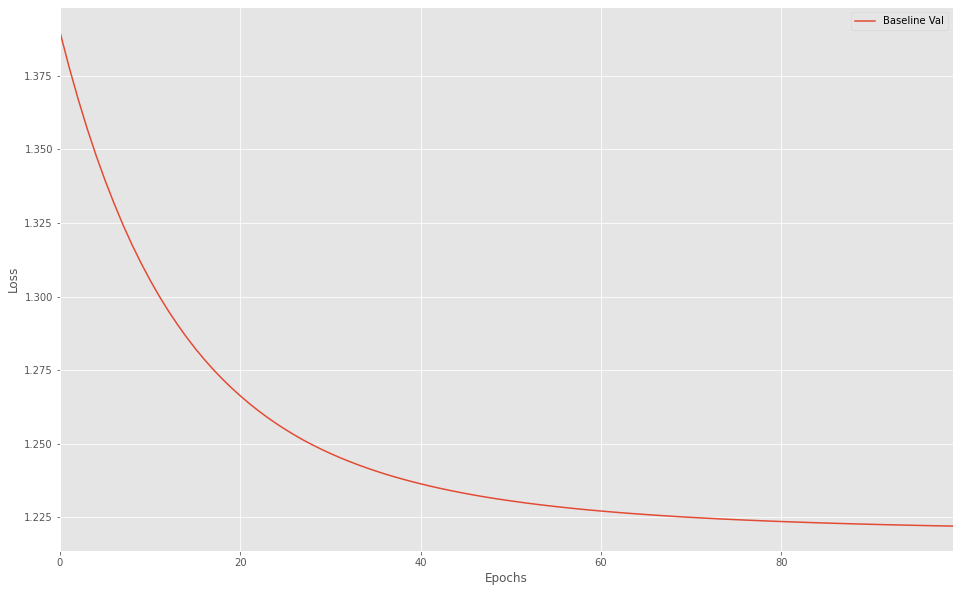

In [17]:
plot_history([('baseline', history1), ],
             start=0)

### Nesterov Momentum

In [18]:
# Первая простенькая моделька 
model2 = fn_model()

# SGD optimizer
sgd = opt.SGD(lr=learning_rate, momentum=0.9, nesterov=True)

# собрали модель
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0)

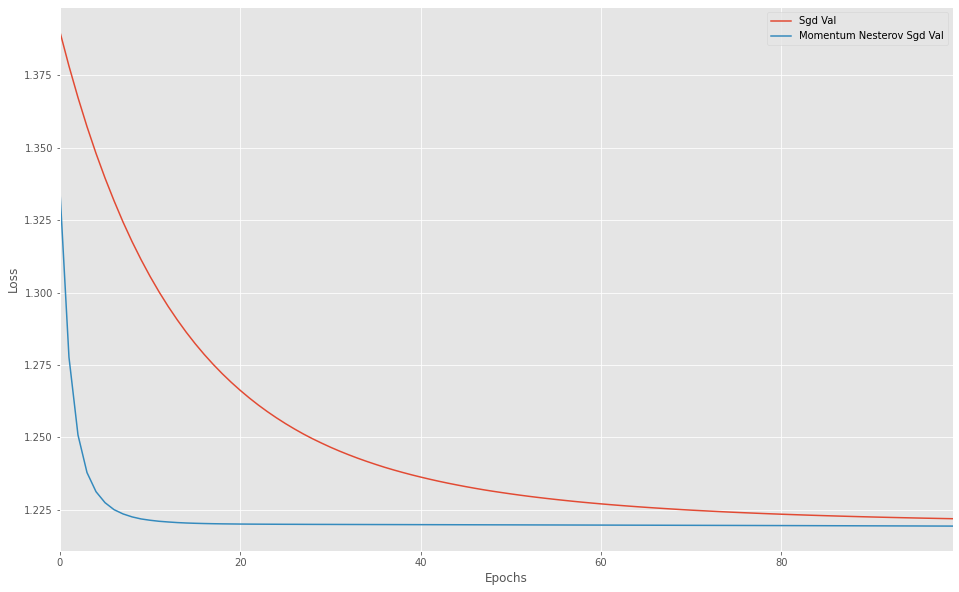

In [19]:
plot_history([('SGD', history1), 
              ('momentum nesterov SGD', history2),],
             start=0)

### RMSprop 

In [20]:
# Первая простенькая моделька 
model3 = fn_model()

# SGD optimizer
sgd = opt.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08)

# собрали модель
model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0)

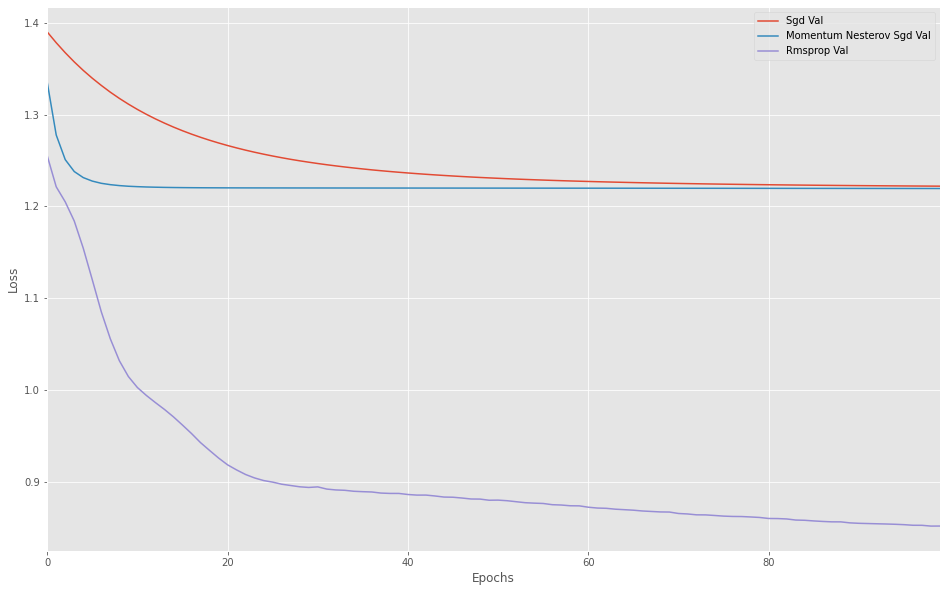

In [21]:
plot_history([('SGD', history1), 
              ('momentum nesterov SGD', history2),
              ('RMSprop', history3),],
             start=0)

### Adam 

In [22]:
# Первая простенькая моделька 
model4 = fn_model()

# SGD optimizer
sgd = opt.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# собрали модель
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history4 = model4.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0)

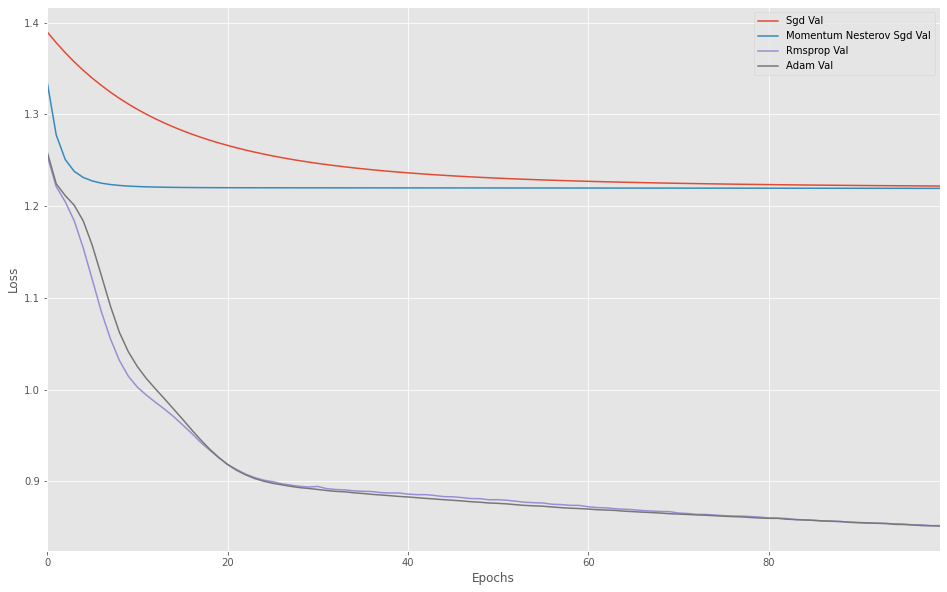

In [23]:
plot_history([('SGD', history1), 
              ('momentum nesterov SGD', history2),
              ('RMSprop', history3),
              ('ADAM', history4),
             ],
             start=0)

# 4. Стратегии с постепенным понижением lr 

![](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_2/ahaha.jpg)

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler # колбэк для корректировки скорости обучения в зависимости от количества эпох
from tensorflow.keras.callbacks import Callback


# Хотим наблюдать за тем как меняется скорость каждую эпоху, для этого делаем свой колбэк!
# Берем базовый класс callback, наследуемся от него (наследуем все методы и атрибуты)
# у него есть методы, которые мы можем переобозначить
class LossHistory(Callback):
    # в логах хранится много информации, можем ее использовать
    # callback принимает на вход логи
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # изменяем learning rate в зависимости от эпохи
        self.lr.append(lr_scheduler(len(self.losses)))
       
    
# функция для картинок, чтобы видеть как скорость обученя меняется от эпохи к эпохе
def plot_learning_rate(loss_history):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1,epochs+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

Стартовую скорость обучения специально берём большой! 

In [28]:
INIT_LR = 0.1  # берём lr намеренно большим

Собираем архитектурку! 

In [38]:
import math 

# Первая простенькая моделька 
model5 = fn_model()

# SGD optimizer
#sgd = opt.SGD(lr=INIT_LR, momentum=0.0, nesterov=False)
sgd = opt.Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# собрали модель
model5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Стратегия для понижения скорости
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 50.0
    # каждые 50 срезаем скорость обучения на 2
    lrate = INIT_LR * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# список из наших колбэков 
loss_history = LossHistory()
lrate = LearningRateScheduler(lr_scheduler)
callbacks_list = [loss_history, lrate]

history5 = model5.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0,
                      callbacks=callbacks_list,
                     )

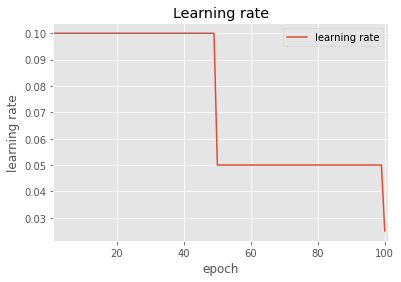

In [39]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(loss_history)

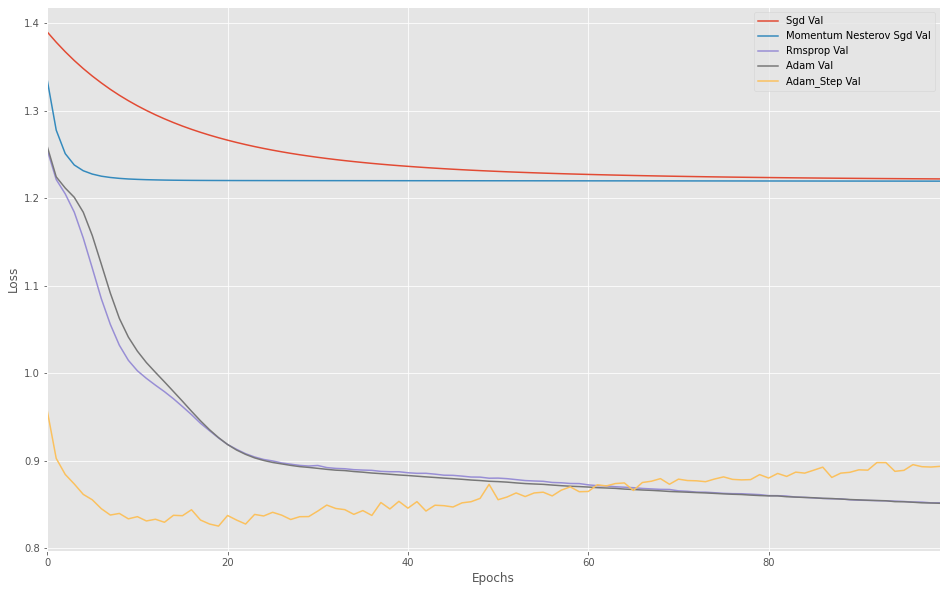

In [40]:
plot_history([('SGD', history1), 
              ('momentum nesterov SGD', history2),
              ('RMSprop', history3),
              ('ADAM', history4),
              ('ADAM_step', history5)
             ],
             start=0)

Попробуем ещё вариант!

In [36]:
# Первая простенькая моделька 
model6 = fn_model()

# SGD optimizer
sgd = opt.Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# собрали модель
model6.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Стратегия для понижения скорости
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 10
    cur_lr = INIT_LR * math.pow(drop, math.floor((epoch)/epochs_drop))
    # скорость обучения не может быть ниже определенного уровня
    if cur_lr > 0.001:
        lrate = INIT_LR * math.pow(drop, math.floor((epoch)/epochs_drop))
    else: 
        lrate = 0.001
    return lrate

# список из наших колбэков 
loss_history = LossHistory()
lrate = LearningRateScheduler(lr_scheduler)
callbacks_list = [loss_history, lrate]

history6 = model6.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0,
                      callbacks=callbacks_list,
                     )

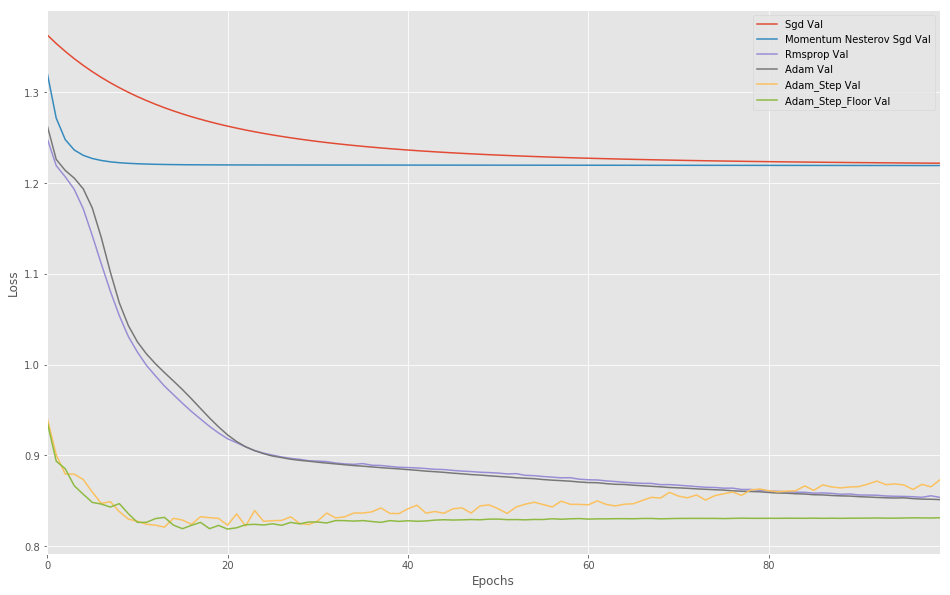

In [37]:
plot_history([('SGD', history1), 
              ('momentum nesterov SGD', history2),
              ('RMSprop', history3),
              ('ADAM', history4),
              ('ADAM_step', history5),
              ('ADAM_step_floor', history6),
             ],
             start=0)

## Авторские права и почиташки 

* Для создания тетрадки использовал [вот этот мануал](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb)

## [10]  Задание 

Пришло время заняться исследованиями! На лекции мы с вами обсудили, что сегодня люди ставят довольно большое число разных экспериментов с циклической скоростью обучения. Делают они это, чтобы как-то соскальзывать с сёдел и выбираться из локальных минимумов.  В этом задании вам надо будет немного поэкспериментировать с такими скоростями обучения в keras. Делать это придётся через колбэки. Это не очень удобно. В чистом Tensorflow можно ставить такие эксперименты в более простом формате.

Поощряются любые эксперименты. Например, в [этом коде](https://github.com/bckenstler/CLR/blob/master/clr_callback.py) есть пример колбэка для циклического перебора скорости обучения. А [вот в этой тетрадке](https://github.com/bckenstler/CLR/blob/master/clr_callback_tests.ipynb) есть пример его применения. Это многофункциональный колбэк, в котором прописано довольно много разных вариантов перебора скорости по циклу. Не копируйте его в слепую, оформляйте код в похожем на то, что было выше формате. Не забывайте строить картинки. Можете как-то видоизменить архитектуру сетки. Например, добавить какие-то новые слои или сделать её глубже. Эксперименты можно оформлять прямо в этой тетрадке. Её же прям мне и присылайте.

__Мы же не data monkey!__ Мы хотим осознавать, что происходит. 

Если хочется вдохновения, [вот в этой статье](https://www.jeremyjordan.me/nn-learning-rate/) можно найти много разных вариантов пересчёта скорости обучения. Есть варианты с циклами и даже косинусами!   

Плодотворных экспериментов :) 

In [31]:
# ваш код